# Exercise 1.2

In [1]:
using LinearAlgebra
using SparseArrays
using Plots
using Optim
using Polynomials

## a)

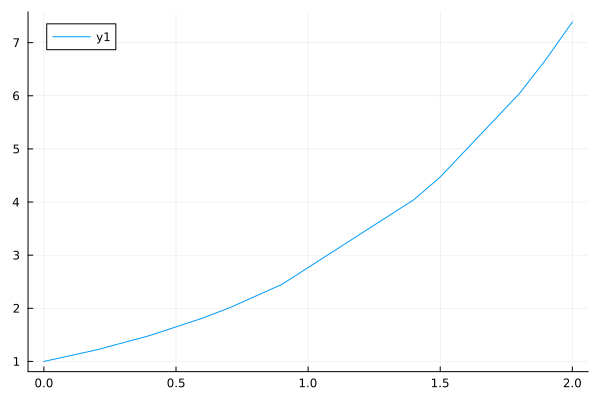

In [2]:
function BVP1D(c::Float64, d::Float64, x::Vector{Float64}) :: Vector{Float64}
    M = length(x)
    
    # Algorithm 1
    A = spzeros(M, M)
    b = zeros(M)

    for i in 1:M-1
        h = x[i+1] - x[i]
        k1 = 1/h + h/3
        k2 = -1/h + h/6

        A[i, i] += k1
        A[i, i+1] = k2
        A[i+1, i] = k2
        A[i+1, i+1] = k1
    end

    
    # Algorithm 2
    b[1] = c
    b[2] -= A[1,2] * c
    b[M-1] -= A[M-1,M] * d
    b[M] = d
    
    A[1,1] = 1
    A[1,2] = 0
    A[2,1] = 0
    A[M, M] = 1
    A[M-1, M] = 0
    A[M, M-1] = 0

    u = A \ b

    return u
end

c = 1.0
d = exp(2)
x = [0.0, 0.2, 0.4, 0.6, 0.7, 0.9, 1.4, 1.5, 1.8, 1.9, 2.0]
u = BVP1D(c, d, x)
plot(x, u)

## b)

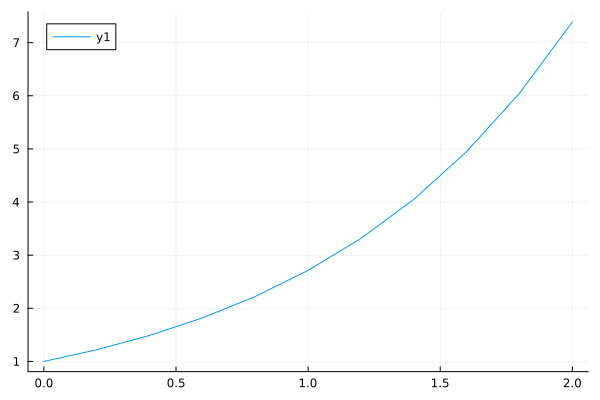

In [3]:
function BVP1D(c::Float64, d::Float64, L::Float64, M::UInt64) :: Tuple{Vector{Float64}, Vector{Float64}}
    x = collect(range(0, L, M))
    u = BVP1D(c, d, x)
    return u, x
end

c = 1.0
d = exp(2)
L = 2.0
M::UInt64 = 11

u, x = BVP1D(c, d, L, M)
plot(x, u)

## c)

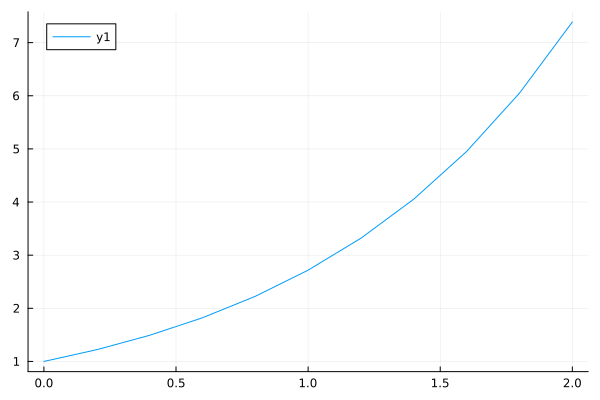

In [4]:
x = collect(range(0, L, M))
plot(x, exp.(x))

## d)

Polynomial(-0.07174784906369909 + 2.0010500256960615*x)

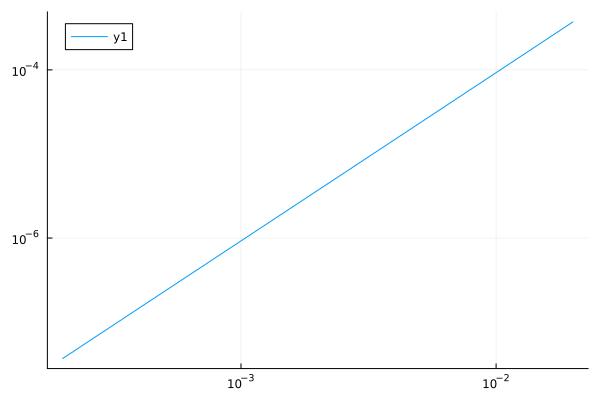

In [5]:
function uhat(x::Float64, xs::Vector{Float64}, us::Vector{Float64}) :: Float64
    i = max(searchsortedfirst(xs, x) - 1, 1)
    h = xs[i+1] - xs[i]
    
    N1 = 1 - (x - xs[i]) / h
    N2 = (x - xs[i]) / h

    return us[i] * N1 + us[i+1] * N2
end

function uhat(x::Vector{Float64}, xs::Vector{Float64}, us::Vector{Float64}) :: Vector{Float64}
    return uhat.(x, Ref(xs), Ref(us))
end

c = 1.0
d = exp(2)
L = 2.0

iterations = 100
step_size = 100
granularity = 100000

hs = zeros(iterations)
max_errors = zeros(iterations)

x_values = collect(range(0, L, granularity))

for i in 1:iterations
    M = i*step_size
    uhat_points, x_points = BVP1D(c, d, L, M)
    error(x) = abs(uhat(x, x_points, uhat_points) - exp(x))

    hs[i] = L / M
    max_errors[i] = maximum(error.(x_values))
end

display(fit(log.(hs), log.(max_errors), 1))
plot(hs, max_errors, xscale=:log10, yscale=:log10)

# Exercise 1.5

## d)

In [6]:
psi = 1
x = collect(range(0,1,10000))

p = plot()
for epsilon in [1, 0.01, 0.0001]
    u(x) = 1/psi * (x - (exp((x-1)*psi/epsilon) - exp(-psi/epsilon))/(1 - exp(-psi/epsilon)))
    plot!(x, u.(x))
end
display(p)

LoadError: cannot define function u; it already has a value

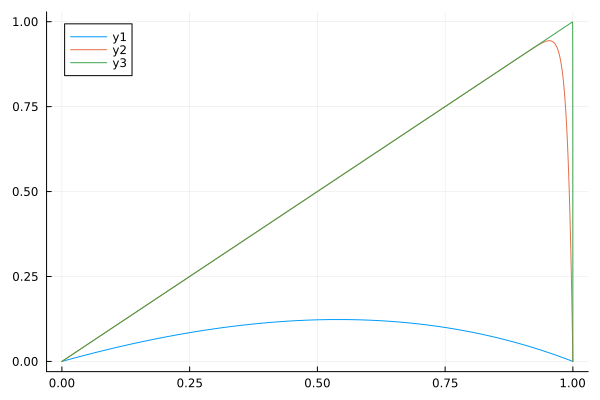

In [ ]:
function LADE1D(psi::Float64, epsilon::Float64, x::Vector{Float64}) :: Vector{Float64}
    M = length(x)
    
    # Algorithm 1
    A = spzeros(M, M)
    b = zeros(M)

    for i in 1:M-1
        h = x[i+1] - x[i]
        psi2 = psi/2
        epsh = epsilon/h

        k11 = psi2 + epsh
        k12 = psi2 - epsh
        k21 = -psi2 - epsh
        k22 = -psi2 + epsh

        A[i, i] += k11
        A[i, i+1] = k12
        A[i+1, i] = k21
        A[i+1, i+1] = k22
    end

    for i in 2:M-1
        b[i] = (x[i+1] - x[i-1]) / 2
    end
    
    # Algorithm 2
    A[1,1] = 1
    A[1,2] = 0
    A[2,1] = 0
    A[M, M] = 1
    A[M-1, M] = 0
    A[M, M-1] = 0

    u = A \ b

    return u
end

psi = 1.0
x = collect(range(0,1,10000))

p = plot()
for epsilon in [1, 0.01, 0.0001]
    u = LADE1D(psi, epsilon, x)
    plot!(x, u)
end
display(p)



In [7]:
function uhat(x::Float64, xs::Vector{Float64}, us::Vector{Float64}) :: Float64
    i = max(searchsortedfirst(xs, x) - 1, 1)
    h = xs[i+1] - xs[i]
    
    N1 = 1 - (x - xs[i]) / h
    N2 = (x - xs[i]) / h

    return us[i] * N1 + us[i+1] * N2
end

function uhat(x::Vector{Float64}, xs::Vector{Float64}, us::Vector{Float64}) :: Vector{Float64}
    return uhat.(x, Ref(xs), Ref(us))
end

psi = 1.0
iterations = 100
step_size = 100
granularity = 100000

for epsilon in [1, 0.01, 0.0001]
    u_anal(x) = 1/psi * (x - (exp((x-1)*psi/epsilon) - exp(-psi/epsilon))/(1 - exp(-psi/epsilon)))
    
    hs = zeros(iterations)
    max_errors = zeros(iterations)
    
    x_values = collect(range(0, 1, granularity))
    
    for i in 1:iterations
        M = i*step_size
        x_points = collect(range(0, 1, M))
        uhat_points = LADE1D(psi, epsilon, x_points)
        error(x) = abs(uhat(x, x_points, uhat_points) - u_anal(x))
    
        hs[i] = 1 / M
        max_errors[i] = maximum(error.(x_values))
    end
    
    display(epsilon)
    display(fit(log.(hs), log.(max_errors), 1))
    display(plot(hs, max_errors, xscale=:log10, yscale=:log10))
end

LoadError: UndefVarError: `LADE1D` not defined

# Exercise 1.6

## a)

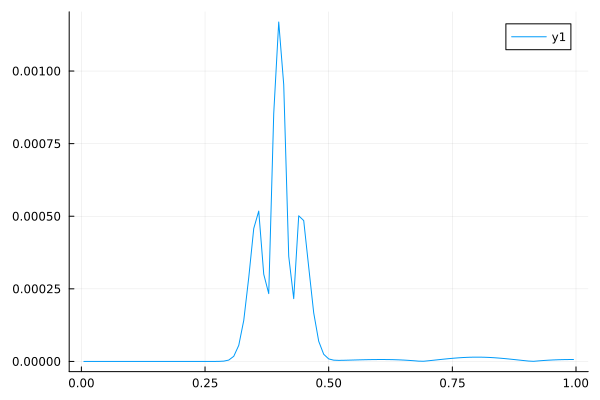

In [16]:
function compute_error_decrease(fun::Function, VX::Vector{Float64}, EToV::Matrix{UInt64})
    M, N = size(EToV)
    err = zeros(M)

    for i in 1:M
        for j in 1:N-1
            k = EToV[i, j]
            k2 = EToV[i, j+1]
            h = VX[k2] - VX[k]
            xi = VX[k]
            err[i] = sqrt(3)*sqrt(h*(fun(xi) + fun(xi + h) - 2*fun(xi + h/2))^2)/6
        end
    end

    return err
end

u_anal(x) = exp(-800*(x - 0.4)^2) + 0.25*exp(-40*(x - 0.8)^2)
M = 100
VX = collect(range(0, 1, M))
EToV = hcat(1:M-1, 2:M)

err_vec = compute_error_decrease(u_anal, VX, EToV)
plot((VX[1:M-1] + VX[2:M])/2, err_vec)

In [13]:
function refine_marked(EToVcoarse::Matrix{UInt64}, xcoarse::Vector{Float64}, idxMarked::Vector{Int64})::Tuple{Matrix{UInt64}, Vector{Float64}}
    M, N = size(EToVcoarse)
    K = length(idxMarked)

    EToVfine = zeros((M + K, N))
    xfine = zeros(length(xcoarse) + K)

    i = 1
    for j in 1:M
        xfine[j+i-1] = xcoarse[j]
        EToVfine[j+i-1, :] = [j+i-1, j+i]

        if i <= K && idxMarked[i] == j
            xfine[j+i] = (xcoarse[j+1] + xcoarse[j])/2
            EToVfine[j+i, :] = [j+i, j+i+1]
            i += 1
        end
    end

    xfine[end] = xcoarse[end]

    return EToVfine, xfine
end

refine_marked (generic function with 1 method)

69

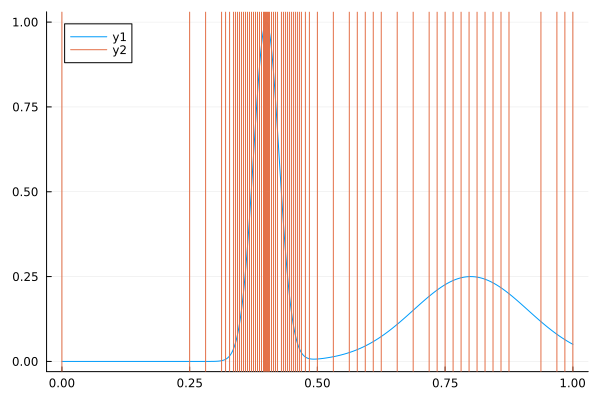

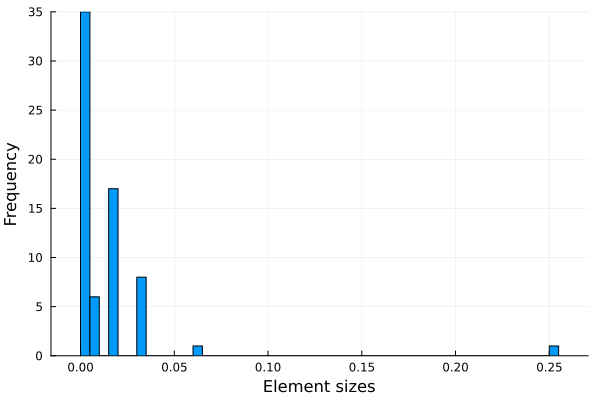

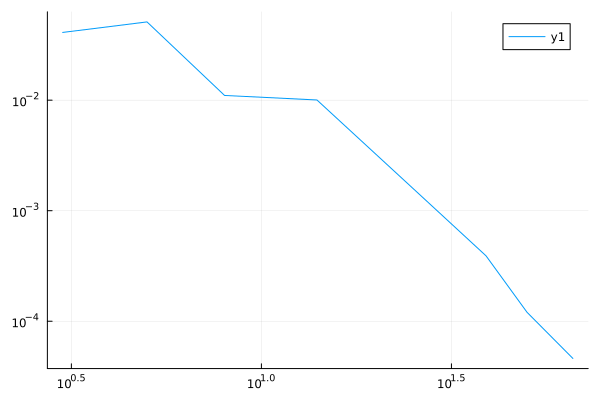

In [20]:
u_anal(x) = exp(-800*(x - 0.4)^2) + 0.25*exp(-40*(x - 0.8)^2)
M = 3
VX = collect(range(0, 1, M))
EToV = hcat(1:M-1, 2:M)
tolerance = 10^(-4)

mean_errors = []
point_counts = []

while true
    err = compute_error_decrease(u_anal, VX, EToV)
    idxMarked = findall(err .>= tolerance)

    if isempty(idxMarked)
        break
    end

    push!(mean_errors, sum(err) / length(err))
    push!(point_counts, length(VX))

    EToV, VX = refine_marked(EToV, VX, idxMarked)
end

display(length(VX))

x = collect(range(0, 1, 1000))
p = plot(x, u_anal.(x))
vline!(VX)
display(p)

hs = VX[2:end] - VX[1:end-1]
display(histogram(hs, bins=100, xlabel="Element sizes", ylabel="Frequency", legend=false))

display(plot(point_counts, mean_errors, xscale=:log10, yscale=:log10))

# Exercise 1.7